In [1102]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [1103]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs, info = env.reset()
# ud = np.array([0])
# yd = obs
# done = False
# start = True

Tini = 1
n = 4
N = 15
m = 1
p = 4
T = (m+1)*(Tini + N + n) - 1
print(T)
render_collection = False

ud = []
yd = []

for i in range(T):
    action = env.action_space.sample()
    # action = np.random.randn(1,)
    # action = np.random.uniform(low=-0.5, high=0.5, size=(m,))
    obs, rew, done, info, _ = env.step(action)
    # if not start:
    #     obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
    # start = False

    if render_collection:
        plt.title(f"Action {action[0]:.3f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    ud = np.append(ud,action)
    yd = np.append(yd,obs)

env.close()
T = len(ud)
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')
print(yd)


39
yd shape : (156,)   ud shape : (39,)
[ 7.35757324e-03 -3.21248030e-03 -1.01972621e-01  2.33973002e-01
  8.48187515e-03 -6.12995717e-03  1.57305366e-01 -3.71919259e-01
  1.40977285e-02 -1.91593604e-02  1.23873980e-01 -2.83384555e-01
  1.74136818e-02 -2.67479719e-02  4.23582293e-02 -1.00144035e-01
 -6.76238468e-04  1.45771258e-02 -9.44168988e-01  2.14324306e+00
 -3.45121389e-02  8.94215731e-02 -7.49808620e-01  1.62132264e+00
 -5.64884533e-02  1.35922859e-01 -3.51621227e-01  7.27080383e-01
 -6.33064099e-02  1.50212060e-01  9.19030751e-03  9.61737283e-04
 -5.79117994e-02  1.41512443e-01  2.60057656e-01 -4.31769213e-01
 -6.07242182e-02  1.57463947e-01 -3.98179091e-01  1.20828893e+00
 -8.79518081e-02  2.33148605e-01 -9.60695273e-01  2.56424968e+00
 -1.29029758e-01  3.43285978e-01 -1.09296402e+00  2.95263464e+00
 -1.89197868e-01  4.99665035e-01 -1.90413584e+00  4.82433618e+00
 -2.64880960e-01  6.95488154e-01 -1.87831936e+00  4.98778873e+00
 -3.42833065e-01  9.06094931e-01 -2.01238211e+00  

In [1104]:
ud

array([-0.31326804,  0.77631867, -0.09472489, -0.24588598, -2.98071146,
        0.54535782,  1.19989896,  1.12486422,  0.81165743, -1.93991971,
       -1.69559538, -0.41529459, -2.60990429, -0.0720119 , -0.69448709,
       -2.62804198, -1.12214458, -1.84365618, -2.17787647,  2.30209327,
        0.6803779 ,  2.77539015, -2.06856012, -1.70697272, -1.48681951,
       -0.6243192 , -1.06818354,  0.74039376,  2.67325115,  2.73643398,
       -0.92040169, -2.44599867,  1.98792112, -1.57780993, -2.58900452,
       -0.47507861,  2.44989419,  2.70077157, -1.1673342 ])

In [1105]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

H has rank 20 and shape (20, 20)


In [1106]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

# u_ini = ud[:Tini]
# y_ini = yd[:p*Tini]
u_ini = np.array([0])
y_ini = np.array([0,0,0,0])
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (16, 24), Up = (1, 24), Uf = (15, 24)
Y = (64, 24), Yp = (4, 24), Yf = (60, 24)
u ini : [0]
y ini : [0 0 0 0]


## Solver

In [1107]:
np.ones(N)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

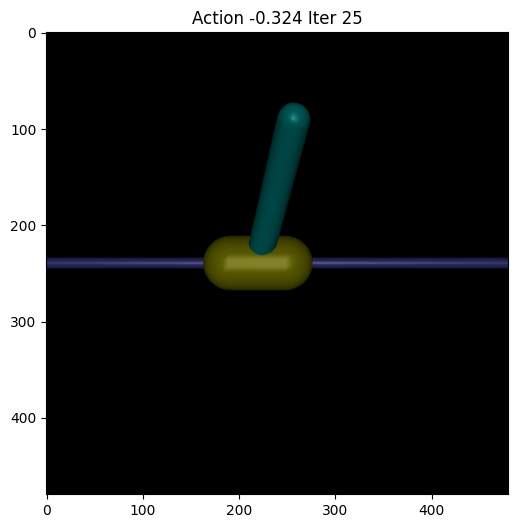

In [1108]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
# sig_y = cp.Variable(p*Tini)

Q = np.diag([1,100,1,1])
Q = np.kron(np.eye(N), Q)
R = np.eye(N)*0.1

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm(g,1)*500 #+ cp.norm(sig_y, 1)*10000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 50
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]
done = False
iter = 0
render_solution = True
y_const = np.kron(np.ones(N), np.array([1000, 0.21, 1000, 1000]))

while not done:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= 3
    # cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  # print(prob.variables()[1].value)
  action = prob.variables()[1].value[0]

  if render_solution:
    plt.title(f"Action {action:.3f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
  
  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
    
  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


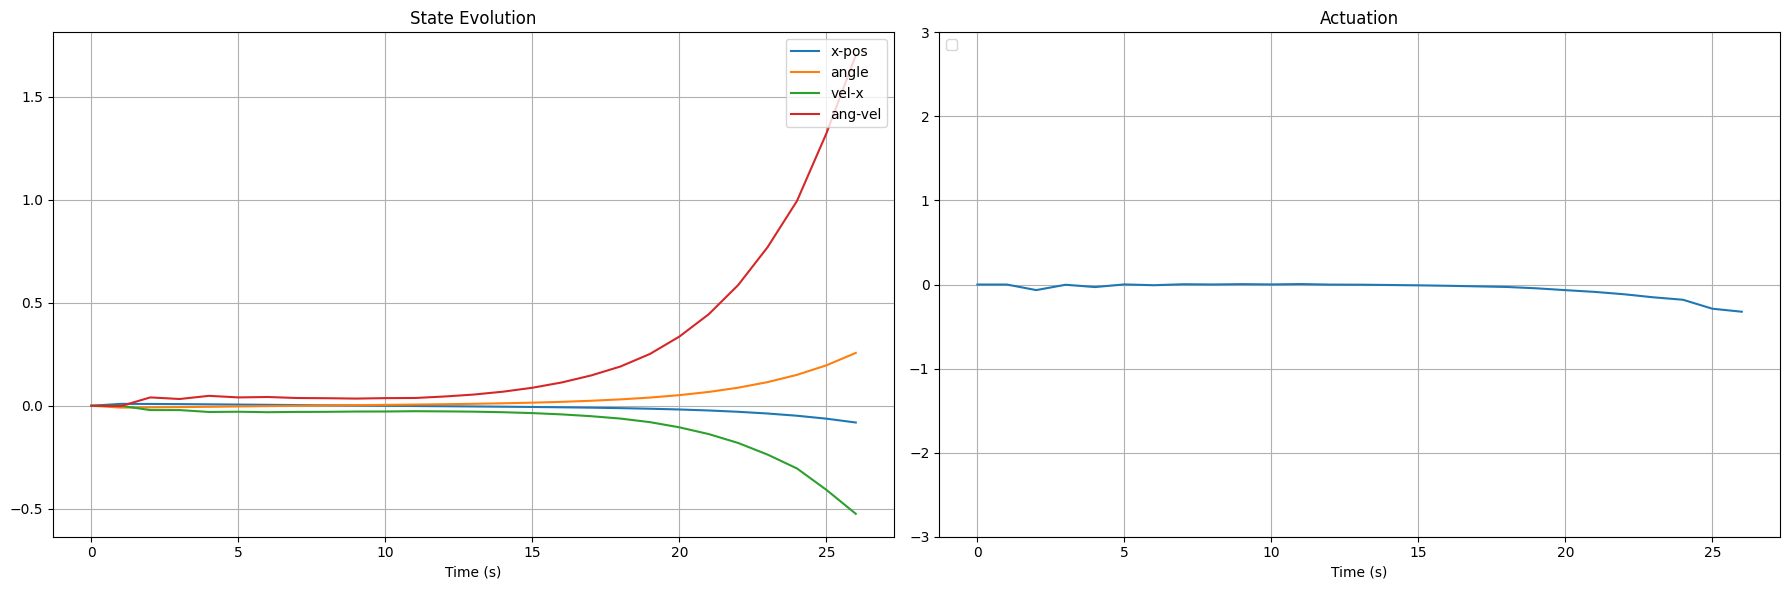

In [1109]:
T = len(uT)
yT = yT.reshape((T,4))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("State Evolution")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,3))
plt.grid('on')
plt.tight_layout()

plt.show()